In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

In [6]:
# select investment universe
data = data[data.dollar_vol_rank<100]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 65 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol             109675 non-null  float64
 2   dollar_vol_1m          109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_low                 109675 non-null  float64
 7   atr                    109675 non-null  float64
 8   macd                   109675 non-null  float64
 9   return_1d              109675 non-null  float64
 10  return_5d              109675 non-null  float64
 11  return_10d             109675 non-null  float64
 12  return_21d             109675 non-null  float64
 13  return_42d    

In [12]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

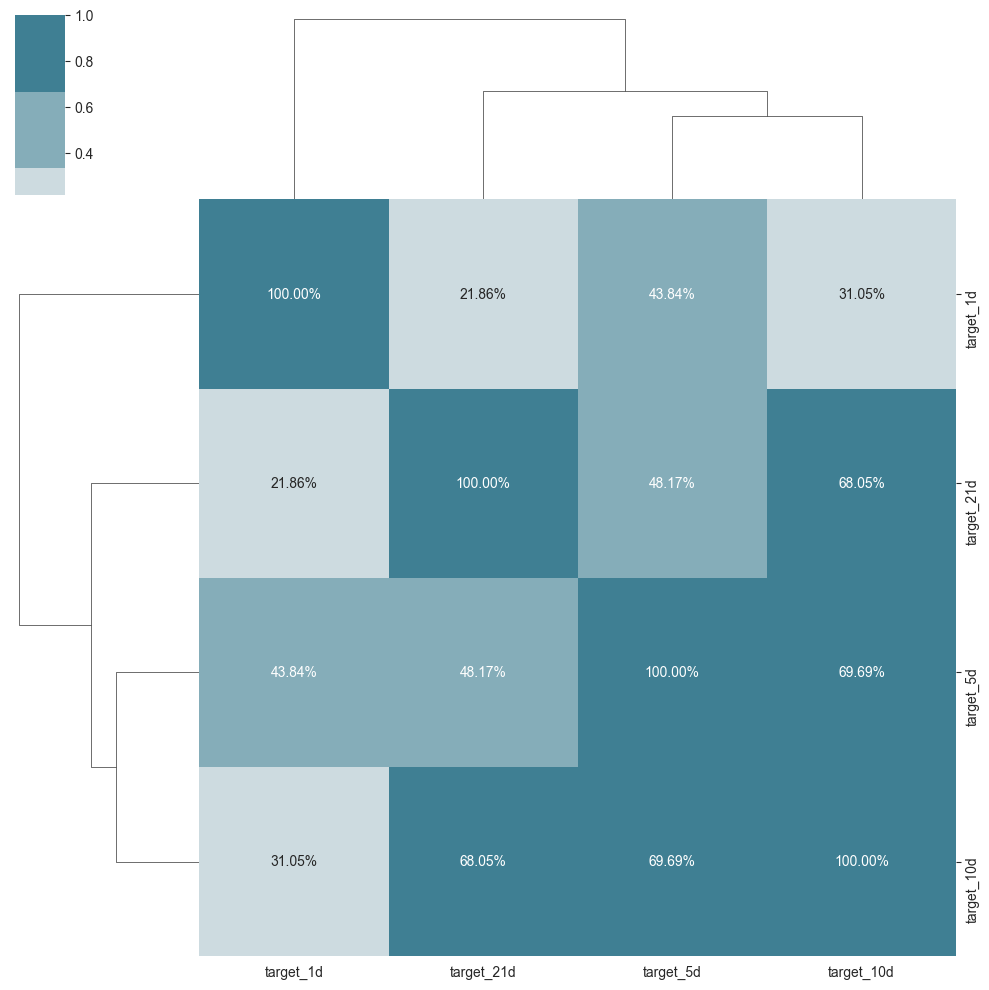

In [14]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

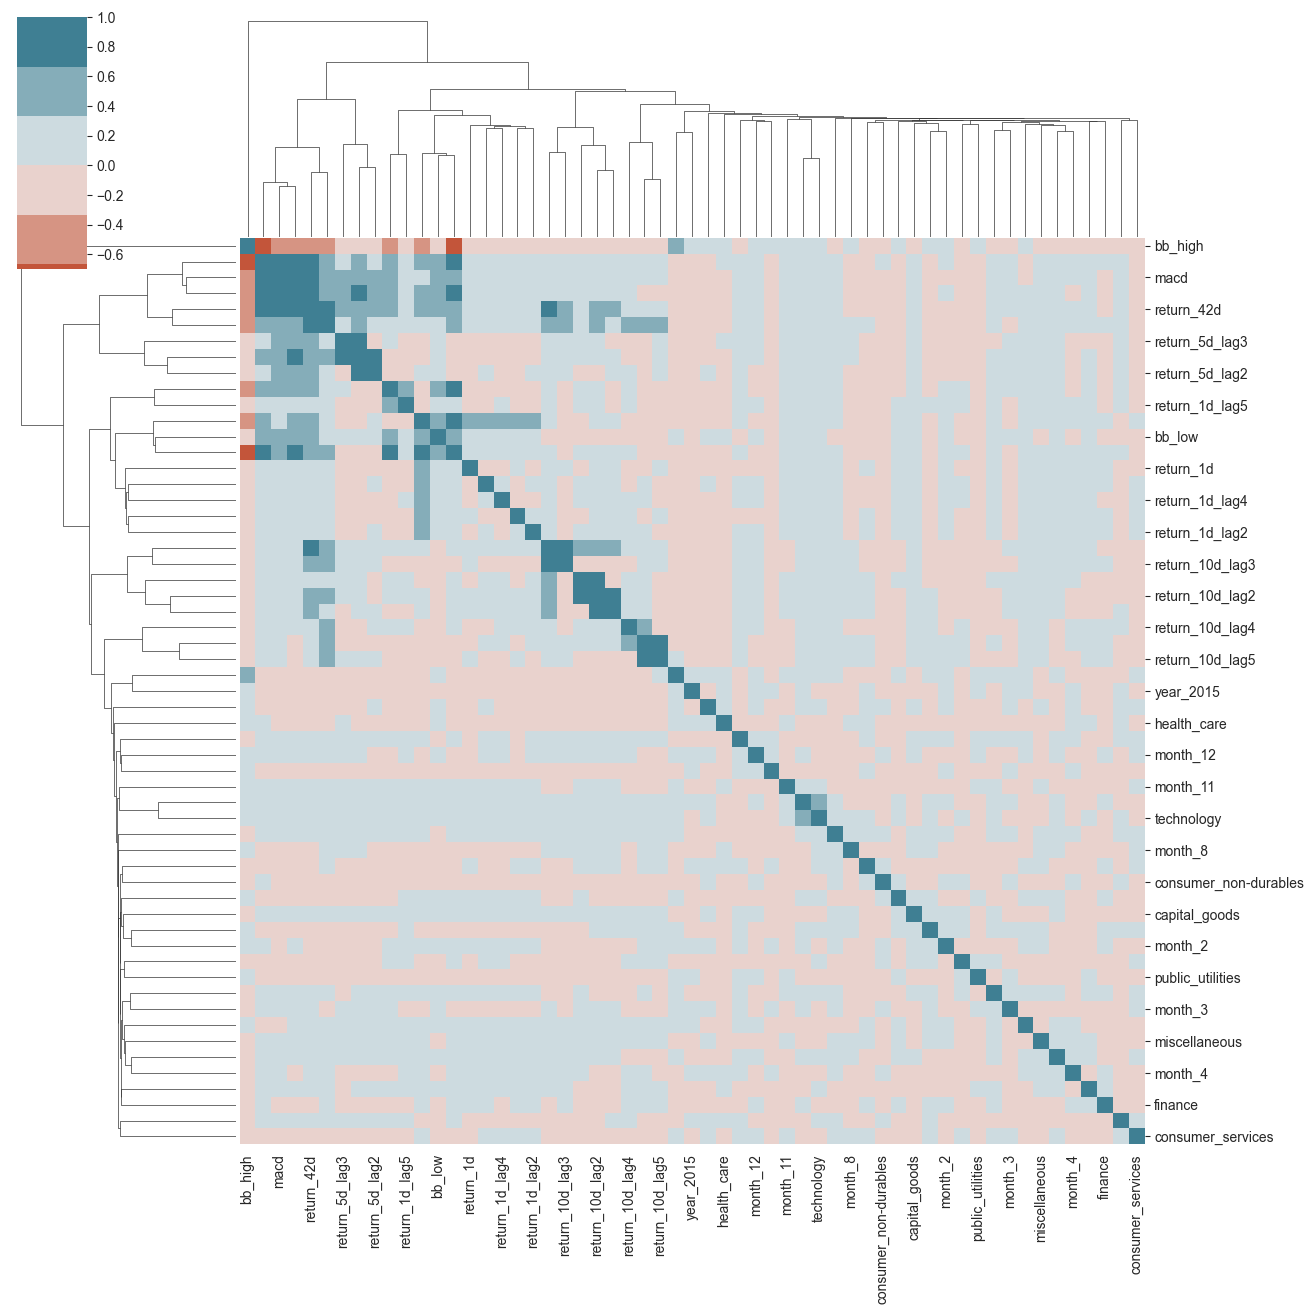

In [15]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [22]:
corr_mat = X.corr().stack().reset_index()

In [24]:
corr_mat.columns = ['var1', 'var2', 'corr']

In [27]:
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

In [31]:
corr_mat.head().append(corr_mat.tail())

,var1,var2,corr
581,return_42d,return_63d,0.835634
637,return_63d,return_42d,0.835634
286,macd,rsi,0.817113
62,rsi,macd,0.817113
518,return_21d,macd,0.793893
515,return_21d,bb_high,-0.632777
122,bb_high,return_10d,-0.693640
458,return_10d,bb_high,-0.693640
59,rsi,bb_high,-0.696555
115,bb_high,rsi,-0.696555


<AxesSubplot:>

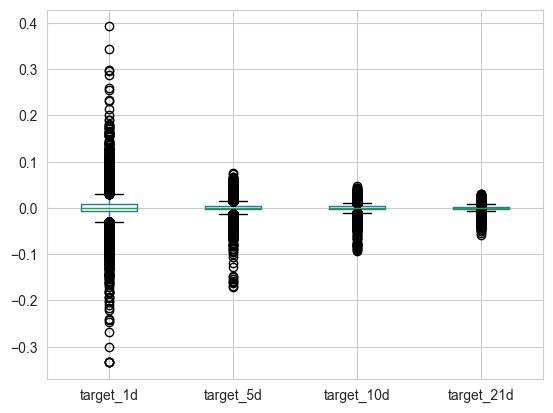

In [33]:
y.boxplot()

## Linear Regression for Statistical Inference: OLS with statsmodels

In [34]:
X

dollar_vol_1m        rsi   bb_high    bb_low       atr  \
ticker date                                                                 
AAL    2013-07-25  223614.661574  69.669475  0.011251  0.140777 -0.383445   
       2013-07-26  234821.351626  72.045207  0.007052  0.146370 -0.412740   
       2013-07-29  243001.954091  73.259776  0.008843  0.146963 -0.494894   
       2013-07-30  243122.621493  72.532538  0.018500  0.142355 -0.565684   
       2013-07-31  256336.659780  73.926238  0.016465  0.139949 -0.653399   
...                          ...        ...       ...       ...       ...   
ZTS    2014-11-28  294715.115434  71.884144  0.043559  0.157493  0.397024   
       2014-12-01  297525.671580  67.137279  0.051976  0.131103  0.403122   
       2014-12-02  298272.515355  68.612084  0.041573  0.120638  0.323857   
       2014-12-03  295315.035852  69.175766  0.038192  0.111125  0.236555   
       2014-12-04  286390.276661  61.677853  0.051743  0.080568  0.273293   

                       macd  return_1d  return_5d  return_10d  return_21d  \
ticker date                                                                 
AAL    2013-07-25  0.681257   0.017838   0.004413    0.008103    0.006426   
       2013-07-26  0.772848   0.013808   0.009262    0.008389    0.007936   
       2013-07-29  0.854980   0.007334   0.011627    0.007984    0.007873   
       2013-07-30  0.904814  -0.001560   0.012430    0.006755    0.007476   
       2013-07-31  0.954135   0.007813   0.009025    0.004774    0.006752   
...                     ...        ...        ...         ...         ...   
ZTS    2014-11-28  2.806829   0.005820   0.008117    0.003841    0.009878   
       2014-12-01  2.691178  -0.012464   0.002269    0.002815    0.008365   
       2014-12-02  2.615256   0.008339   0.000717    0.001147    0.009064   
       2014-12-03  2.540352   0.003129   0.004380    0.001551    0.008311   
       2014-12-04  2.329735  -0.019608  -0.003018    0.001374    0.005614   

                   ...  capital_goods  consumer_non-durables  \
ticker date        ...                                         
AAL    2013-07-25  ...              0                      0   
       2013-07-26  ...              0                      0   
       2013-07-29  ...              0                      0   
       2013-07-30  ...              0                      0   
       2013-07-31  ...              0                      0   
...                ...            ...                    ...   
ZTS    2014-11-28  ...              0                      0   
       2014-12-01  ...              0                      0   
       2014-12-02  ...              0                      0   
       2014-12-03  ...              0                      0   
       2014-12-04  ...              0                      0   

                   consumer_services  energy  finance  health_care  \
ticker date                                                          
AAL    2013-07-25                  0       0        0            0   
       2013-07-26                  0       0        0            0   
       2013-07-29                  0       0        0            0   
       2013-07-30                  0       0        0            0   
       2013-07-31                  0       0        0            0   
...                              ...     ...      ...          ...   
ZTS    2014-11-28                  0       0        0            1   
       2014-12-01                  0       0        0            1   
       2014-12-02                  0       0        0            1   
       2014-12-03                  0       0        0            1   
       2014-12-04                  0       0        0            1   

                   miscellaneous  public_utilities  technology  transportation  
ticker date                                                                     
AAL    2013-07-25              0                 0           0               1  
       2013-07-26           

In [40]:
sectors = X.iloc[:, -10:]
X = X.drop(sectors.columns, axis=1).groupby(level='ticker').transform(lambda x: (x-x.mean())/x.std()).join(sectors).fillna(0)

In [41]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     19.03
Date:                Wed, 15 Feb 2023   Prob (F-statistic):          9.43e-189
Time:                        22:45:54   Log-Likelihood:             2.8852e+05
No. Observations:              109675   AIC:                        -5.769e+05
Df Residuals:                  109617   BIC:                        -5.764e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

In [42]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     61.86
Date:                Wed, 15 Feb 2023   Prob (F-statistic):               0.00
Time:                        22:46:33   Log-Likelihood:             3.7883e+05
No. Observations:              109675   AIC:                        -7.575e+05
Df Residuals:                  109617   BIC:                        -7.570e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

In [44]:
preds = trained_model.predict(add_constant(X))
residuals = y[target]-preds

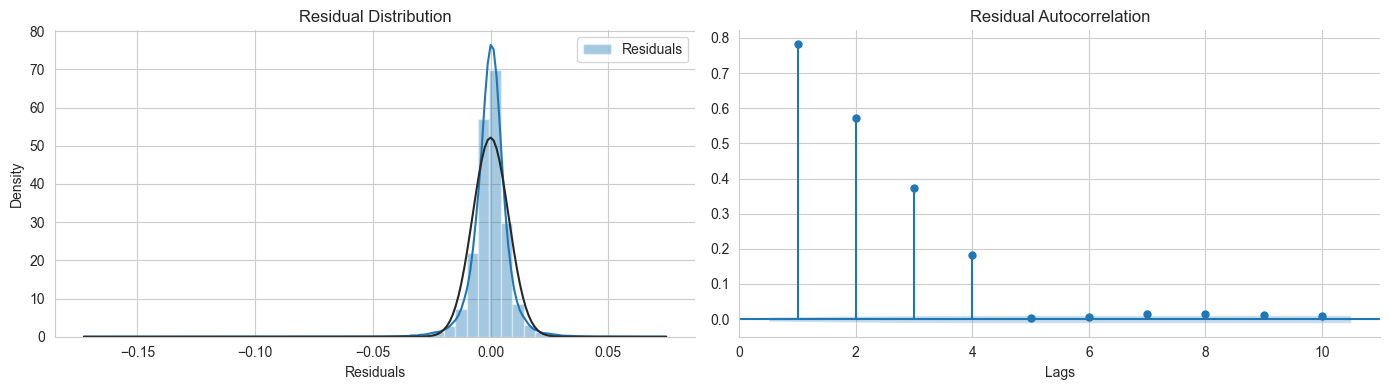

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();